# Background Information

Resampling methods involve repeatedly drawing samples from a training set and refitting a model on each sample in order to obtain additional information about the fitted model.

Two of the most commonly used resampling methods are called **cross-validation** and **bootstrapping**. 

Cross-validation is used to estimate the test error of a model, in order to evaluate model performance. 

The bootstrap is used in several contexts, usually to provide a measure of accuracy of a parameter estimate or of a given statistical learning method. 

## Cross-Validation
We estimate the test error rate by holding out a subset of the training observations from the fitting process, and then apply the statistical learning method on those held-out observations.

### Validation Set Approach
This approach randomly divides the available set of observations into two parts: a training set and a validation set, generally of comparable sizes (eg. 50/50)

There are two potential drawbacks
1. The validation estimate of the test error rate can be highly variable, depending on precisely which observations are included in the training set and which are included in the validation set
2. Since only a subset of the total observations are used to fit the model, the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set. 

### Leave-One-Out Cross Validation (LOOCV)
Instead of creating two subsets of comparable size, a single observation, $(x_1, y_1)$ is used for the validation set and the remaining observations make up the training set. The mean squared error is given as $MSE_1 = (y_1 - \hat{y}_1)^2$, which is an estimate for the test error.

We can repeat the procedure, by selecting the next point $(x_2, y_2)$ as the validation point, and we repeat until we go through all of the points, generating an MSE for each. The cross-validation estimate of the test MSE is given as: $ CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n}MSE_i $

LOOCV has far less bias and tends to not overestimate the test error rate. The LOOCV approach will also yield the same results every time. However, it has the potential to be expensive to implement, since the model has to be fit n times. 

However, the LOOCV for least squares linear or polynomial regression can be computed with the same cost of a single model fit using the following formula:

$$ CV_{(n)} = \frac{1}{n} \sum_{i=1}^{n}\Big(\frac{y_i-\hat{y}_i}{1-h_i}\Big)^2 $$

where $h_i$ is the leverage of the point, which reflects the amount of influence that an observation has the on overall fit. 

### k-Fold Cross-Validation
This approach involves randomly dividing the set of observations into k groups, or folds, of approximately equal size. 

The first fold is treated as the validation set, and the method is fit on the remaining $k-1$ folds. $MSE_1$ is then computed on the held-out observations. The process is repeated k times. The k-fold CV estimate is then given as:

$$ CV_{(k)} = \frac{1}{k} \sum_{i=1}^{k} MSE_i $$

LOOCV is thus a special case of k-fold CV where k = n. In practice, k is usually equal to **5 or 10**. 

#### Bias-Variance Trade-Off for k-Fold Cross-Validation

k-fold CV actually tends to give more accurate estimates of the test error rate than LOOCV, since it turns out that LOOCV has higher variance than does k-fold CV. 

With LOOCV, we're averaging the outputs of n fitted models, which are trained on an almost identical set of observations. Thus, these outputs are highly correlated with each other. With k-fold CV, the training set overlap is smaller, so the outputs are somewhat less correlated with each other. The mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated. 

We use $k=5$ or $k=10$ because these have been empirically shown to suffer neither from excessively high bias nor from very high variance. 

### Cross-Validation on Classification Problems
Rather than use MSE to quantify test error, we instead just use the number of misclassified observations. 

$$ CV_{(n)} = \frac{1}{n} \sum_{i=1}^n Err_i $$

where $Err_i = I(y_i \ne \hat{y}_i)$. 

## The Bootstrap

Bootstrapping is any test or metric that relies on random sampling with replacement. The basic idea is to make inference about an estimate for a population parameter using sample data. 

We randomly select n observations from the data set (where n is equal to the number of observations in the data set) in order to produce a bootstrap data set, $Z^{*1}$. This sampling is performed *with replacement*. We use $Z^{*1}$ to produce a bootstrap estimate of our parameters. For sake of simplicity, let's say there's one parameter $\alpha$. This process is repeated B times in order to produce B different bootstrap sets, $Z^{*1}, Z^{*2}, ..., Z^{*B}$ and B corresponding parameter estimates, $\hat{\alpha}^{*1}, ... \hat{\alpha}^{*B}$.

You can then do things like obtain a confidence interval for $\alpha$ or the standard error. The standard error of $\hat{\alpha}$ is given by:

$$ SE_B(\hat{\alpha}) = \sqrt{\frac{1}{B-1} \sum_{r=1}^B \bigg(\hat{\alpha}^{*r} - \frac{1}{B}\sum_{r'=1}^B \hat{\alpha}^{*r'}\bigg)^2} $$

In the case of model selection, you may want to choose the model that gives the least variance on bootstrapped estimates of the parameters. 

# Lab: Cross-Validation and the Bootstrap

## Leave One Out Cross-Validation Score

In [4]:
import numpy as np
import pandas as pd

np.random.seed(10)
auto = pd.read_csv('Data/auto.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [26]:
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = auto[['cylinders', 'displacement', 'origin']] 
y = auto['mpg']

# Note that we're not taking advantage of being able to use the leverage to calculate the LOO CV score
# But this method will apply to any statistical learning method

errors = []
for train_index, test_index in LeaveOneOut().split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse = mean_squared_error(y.iloc[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)

In [27]:
# LOO CV Score
np.mean(errors)

21.186778120679175

## k-Fold Cross Validation

In [28]:
kf = KFold(n_splits=10)
errors = []

for train_index, test_index in kf.split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse = mean_squared_error(y.iloc[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)
# The error is higher than the LOOCV error
np.mean(errors)

23.904945665990113

# Exercises: Conceptual

1. We now review k-fold cross validation
  1. Explain how k-fold cross validation is implemented
  2. What are the advantages and disadvantages of k-fold cross-validation relative to: 
    1. The validation set approach?
    2. LOOCV?
2. Suppose that we use some statistical learning method to make a prediction for the respone Y for a particular value of the predictor X. Carefully describe how we might estimate the standard deviation of our prediction

1. 
  1. K-Fold CV randomly splits a data set into k groups. The first time you fit the model, you use the first group as the test data and the remaining groups as the training data. The second time, you use the the second group as the test data, and the remaining groups as the training. You continue until you've fitted k models and have made each group the test set. You take the average of the k test scores as the k-fold cross-validation score.
  2. 
    1. The validation set approach may significantly overestimate the test error because it leaves about 50% of the total observations out of the training data. If you have relatively few training observations, this can cause lots of variance in your models and test error scores. K-Fold CV is often done with 5 or 10 folds, meaning either 20% or 10% of the overall data is left out from the training set. 
    2. LOOCV is more computationally expensive and has a higher variance than K-Folds. 
2. You can generate B bootstrapped samples of X and Y and fit the model for each sample. You can then get the standard deviation of the predicted Y's from the bootstrapped samples. 

# Exercises: Applied

## Default Data Set
1. In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. 
  1. Fit a logistic regression model that uses `income` and `balance` to predict `default`
  2. Using the validation set approach, estimate the test error of this model. In order to do this, perform the following steps
    1. Split the sample set into a training and validation set
    2. Fit a multiple logistic regression model using only the training set
    3. Obtain a prediction of default status for each individual in the validation set 
    4. Compute the validation set error
  3. Repeat the process in 1b 3 times and comment on the results obtained
  4. Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including the dummy varaible for `student` leads to a reduction in the test error rate
2. Now we'll compute estimates for the standard errors of the `income` and `balance` coefficients in two different ways: using the bootstrap and using the standard formula for computing the standard errors
  1. Use the summary function of `statsmodels` to determine the estimated standard errors of the coefficients associated with `income` and `balance`
  2. Write a function that takes as input the `Default` data set as well as the index of the observations and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model
  3. Estimate the standard errors of the logistic regression coefficients
  4. Comment on the estimated standard errors obtained in 1 and 3

In [29]:
import numpy as np
import pandas as pd

default = pd.read_csv('Data/default.csv')
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [30]:
default['student_01'] = (default['student'] == 'Yes').astype('int')
default['default_01'] = (default['default'] == 'Yes').astype('int')
default.head()

,default,student,balance,income,student_01,default_01
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,1,0
2,No,No,1073.549164,31767.138947,0,0
3,No,No,529.250605,35704.493935,0,0
4,No,No,785.655883,38463.495879,0,0


In [36]:
X = default[['balance', 'income']]
y = default['default_01']

In [37]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [38]:
log_reg.intercept_

array([-11.54047811])

In [39]:
log_reg.coef_

array([[5.64710797e-03, 2.08091984e-05]])

In [54]:
# Validation Set Cross-Validation
from sklearn.model_selection import train_test_split

np.random.seed(10)
scores = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
    log_reg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    scores.append(log_reg.score(X_test, y_test))
scores

# The scores are actually fairly consistent

[0.967, 0.9728, 0.9636]

In [56]:
# Adding the student variable
X = default[['balance', 'income', 'student_01']]
scores = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
    log_reg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    scores.append(log_reg.score(X_test, y_test))
scores

# The accuracy is quite similar, just slightly lower on average 

[0.9656, 0.966, 0.9654]

In [57]:
import statsmodels.formula.api as smf

In [59]:
results = smf.logit(formula='default_01 ~ balance + income', data=default).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             default_01   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                  0.4594
Time:                        16:42:14   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [65]:
df_params = pd.DataFrame(columns=['Intercept', 'balance', 'income'])

for i in range(100):
    default_sample = default.sample(frac=0.75, replace=True)
    results_sample = smf.logit(formula='default_01 ~ balance + income', data=default_sample).fit(disp=0)
    df_params = df_params.append(results_sample.params, ignore_index = True)

In [66]:
df_params

,Intercept,balance,income
0,-11.001338,0.005355,0.000018
1,-11.710704,0.005735,0.000023
2,-11.606816,0.005563,0.000026
3,-11.132899,0.005414,0.000019
4,-11.276914,0.005341,0.000023
5,-11.656566,0.005707,0.000024
6,-12.078848,0.006038,0.000018
7,-12.290239,0.006007,0.000023
8,-11.193440,0.005407,0.000016
9,-11.002161,0.005363,0.000017


In [68]:
# Bootstrap parameters 
# The standard deviation is a bit higher in the bootstrapped samples
df_params.describe()

,Intercept,balance,income
count,100.000000,100.000000,100.000000
mean,-11.608120,0.005690,0.000020
std,0.498679,0.000283,0.000005
min,-12.915352,0.005090,0.000006
25%,-11.906720,0.005454,0.000017
50%,-11.638394,0.005708,0.000020
75%,-11.244482,0.005901,0.000024
max,-10.453901,0.006390,0.000033


## Simulated Data Set
1. We will perform cross-validation on a simulated data set
  1. Generated simulated data as follows
  ```
  np.random.seed(1)
  x = np.random.randn(100)
  e = np.random.randn(100)
  y = x - 2*x**2 + e
  ```
  What is n and what is p? Write out the equation form
  2. Create a scatterplot of X against Y
  3. Set a random seed and then compute the LOOCV errors that result from fitting the following four models using least squares:
    1. $ Y = \beta_0 + \beta_1X + \epsilon $
    2. $ Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon $
    3. $ Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon $
    4. $ Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta+3X^3 + \beta_4X^4 + \epsilon$
  4. Repeat c) with another random seed and report your results
  5. Which of the models in c) had the lowest LOOCV error? Is this what you expected?
  6. Comment on the statistical significance of the coefficient estimates that resulted from fitting each of the models. Do these results agree with conclusions drawn based on the cross-validation results?

In [3]:
np.random.seed(1)
x = np.random.randn(100)
e = np.random.randn(100)
y = x - 2*x**2 + e

Here, we have n = 100 and p = 1. 
$$ \beta_0 = 0 $$
$$ \beta_1 = 1 $$
$$ \beta_2 = -2 $$
$$ \beta_3 = \beta_4 = 0 $$

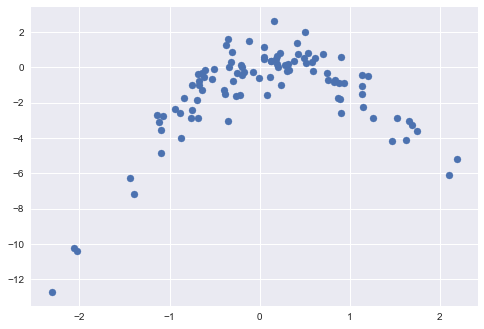

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.scatter(x, y)
plt.show()

In [9]:
import pandas as pd

df = pd.DataFrame(np.array([np.ones(len(x)), x, x**2, x**3, x**4, y]).T, columns = ['b0', 'x', 'x2', 'x3', 'x4', 'y'])
df.head()

,b0,x,x2,x3,x4,y
0,1.0,1.624345,2.638498,4.285832,6.961671,-4.099779
1,1.0,-0.611756,0.374246,-0.228947,0.140060,-0.135741
2,1.0,-0.528172,0.278965,-0.147342,0.077822,-0.682611
3,1.0,-1.072969,1.151262,-1.235268,1.325403,-2.781913
4,1.0,0.865408,0.748930,0.648130,0.560897,-1.727365


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

In [21]:
np.random.seed(5)
errors = []
X = df[['b0', 'x']]
for train_index, test_index in LeaveOneOut().split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y[train_index])
    mse = mean_squared_error(y[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)
np.mean(mse)

2.57424533508528

In [22]:
np.random.seed(5)
errors = []
X = df[['b0', 'x', 'x2']]
for train_index, test_index in LeaveOneOut().split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y[train_index])
    mse = mean_squared_error(y[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)
np.mean(mse)

0.7233222659285132

In [23]:
np.random.seed(5)
errors = []
X = df[['b0', 'x2', 'x3']]
for train_index, test_index in LeaveOneOut().split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y[train_index])
    mse = mean_squared_error(y[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)
np.mean(mse)

2.252326733018285

In [25]:
np.random.seed(5)
errors = []
X = df[['b0', 'x2', 'x3', 'x4']]
for train_index, test_index in LeaveOneOut().split(X):
    reg = LinearRegression().fit(X.iloc[train_index], y[train_index])
    mse = mean_squared_error(y[test_index], reg.predict(X.iloc[test_index]))
    errors.append(mse)
np.mean(mse)

2.40683427704436

We see that the errors are minimized with $ Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon $, which is the true model

If we run this again with a different seed, the results will be the exact same since it evaluates all possible combinations with 1 test observation

In [28]:
# Let's run this model with statsmodels so we can see statistical significance

import statsmodels.formula.api as smf

results = smf.ols('y ~ x', data = df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Wed, 03 Apr 2019   Prob (F-statistic):            0.00209
Time:                        14:21:26   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4131      0.242     -5.849      0.000      -1.893      -0.934
x              0.8610      0.272      3.162      0.002       0.321       1.401
==============================================================================
Omnibus:                       37.310   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.521
Skew:                          -1.554   Prob(JB):                     8.01e-16
Kurtosis:                       5.651   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# both x and x2 are statistically significant, as expected
results = smf.ols('y ~ x + x2', data = df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     304.9
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           1.47e-42
Time:                        14:22:56   Log-Likelihood:                -134.42
No. Observations:                 100   AIC:                             274.8
Df Residuals:                      97   BIC:                             282.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1350      0.115      1.169      0.245      -0.094       0.364
x              1.0936      0.107     10.229      0.000       0.881       1.306
x2            -1.9846      0.085    -23.331      0.000      -2.153      -1.816
==============================================================================
Omnibus:                        0.893   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.552
Skew:                          -0.170   Prob(JB):                        0.759
Kurtosis:                       3.132   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# x3 is not statistically significant
results = smf.ols('y ~ x + x2 + x3', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     204.8
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           1.40e-41
Time:                        15:14:32   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1280      0.115      1.111      0.269      -0.101       0.357
x              0.9065      0.187      4.842      0.000       0.535       1.278
x2            -1.9753      0.085    -23.187      0.000      -2.144      -1.806
x3             0.0788      0.065      1.216      0.227      -0.050       0.208
==============================================================================
Omnibus:                        1.539   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.081
Skew:                          -0.236   Prob(JB):                        0.583
Kurtosis:                       3.193   Cond. No.                         5.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# however, x4 is statistically significant
# perhaps there is some overfitting
results = smf.ols('y ~ x + x2 + x3 + x4', data = df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     163.0
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           1.24e-41
Time:                        15:14:04   Log-Likelihood:                -130.63
No. Observations:                 100   AIC:                             271.3
Df Residuals:                      95   BIC:                             284.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3140      0.136      2.311      0.023       0.044       0.584
x              0.9127      0.183      4.999      0.000       0.550       1.275
x2            -2.5445      0.248    -10.264      0.000      -3.037      -2.052
x3             0.0992      0.064      1.556      0.123      -0.027       0.226
x4             0.1394      0.057      2.437      0.017       0.026       0.253
==============================================================================
Omnibus:                        1.537   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.088
Skew:                          -0.238   Prob(JB):                        0.581
Kurtosis:                       3.184   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Boston Data Set

1. 
  1. Based on this data set, provide an estimate for the population mean of `medv`, call it $\hat{\mu}$
  2. Provide an estimate of the standard error $\hat{\mu}$. Hint: The standard error can be given by dividing the sample standard deviation by the square root of the number of observations
  3. Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does it compare to the answer from b?
  4. Based on the bootstrap estimate from c, provide a 95% confidence interval for the mean of `medv`. Hint, you can use $[\hat{\mu} - 2SE(\hat{\mu}), \hat{\mu}+2SE(\hat{\mu})]$. 
  5. Based on the data, provide an estimate $\hat{\mu}_{med}$ for the median value of `medv` of the population
  6. Estimate the standard error of the median using the bootstrap. 
  7. Based on this data set, provide an estimate for the 10th percentile of `medv`. Call this quantity $\hat{\mu}_{0.1}$
  8. Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$

In [42]:
boston = pd.read_csv('Data/boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [44]:
boston['medv'].mean()

22.532806324110698

In [48]:
# Standard Error
boston['medv'].std() / np.sqrt(boston.shape[0])

0.4088611474975351

In [52]:
# bootstrap standard error
# 1000 is pretty standard for # of bootstrap samples
means = [boston['medv'].sample(n=len(boston), replace=True).mean() for i in range(1000)]
np.std(means)
# the bootstrapped standard error is pretty close

0.4171312611340175

In [53]:
# 5%

boston['medv'].mean() - 2*np.std(means)

21.698543801842664

In [54]:
# 95%

boston['medv'].mean() + 2*np.std(means)

23.367068846378732

In [55]:
boston['medv'].median()

21.2

In [57]:
medians = [boston['medv'].sample(n=len(boston), replace=True).median() for i in range (1000)]
np.std(medians)

0.3694604038323996

In [58]:
boston['medv'].quantile(0.10)

12.75

In [59]:
quantiles = [boston['medv'].sample(n=len(boston), replace=True).quantile(0.10) for i in range(1000)]
np.std(quantiles)

0.51466376402463